In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from matrix_neural_net import Network
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

class TqdmUpdate(tqdm):
     def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# load images and labels of the MNIST data set 
# each element in x_train/x_test is a handwritten digit
# and each element in y_train/y_test is the associated 
# label for that digit (0-9)
if not os.path.exists('./data/mnist/X.npy'):
    from mnist import MNIST

    mnist = MNIST('./data/mnist')
    
    x_train, y_train = mnist.load_training() #60000 samples
    x_test, y_test = mnist.load_testing()    #10000 samples

    
    X = np.append(x_train, x_test)
    y = np.append(y_train, y_test)
    np.save('./data/mnist/X', X)
    np.save('./data/mnist/y', y)

X = np.load('./data/mnist/X.npy')
X = X.reshape(70000, 28, 28)
# divide by 255 to normalize values
X = np.array([ (x.flatten())/255 for x in X])

y = np.load('./data/mnist/y.npy')
y = y.reshape(70000, )
y = np.array([int(i) for i in y])

# One hot encode the y data (target variable)
temp = np.zeros((y.size, int(y.max())+1))
temp[np.arange(y.size),y] = 1
y = temp

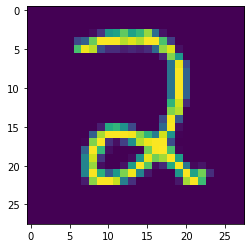

In [16]:
# example of one of the handwritten digits
plt.imshow(X[432].reshape((28,28)))

In [17]:
np.argmax(y[432])

2

In [18]:
# each image is 28x28 pixels, which is flattened
# out into an input array of length 784
len(X[0])

784

In [19]:
# instatiate network with sigmoid activation
# this shape returns an ~96% testing accuracy 
# and takes about 9min to train on the MNIST 
# dataset (60,000 images) on an intel pentium, 
# 8Gb memory
network = Network(
    shape=[784, 200, 80, 10], 
    activation = 'tanh', output_activation='sigmoid'
)

In [20]:
# verify that the forwad pass works and provides an 
# output with a probability for each label
guess = network.forward_pass(X[0])
guess

array([0.03457296, 0.00633134, 0.39123202, 0.00250011, 0.99247274,
       0.93887929, 0.00308971, 0.99668761, 0.63171829, 0.99999236])

In [21]:
# the position of the highest probability is taken
# to be the network's output
interpret = lambda x: np.argmax(x)
interpret(guess)

9

In [22]:
# verify that the backwards pass works
network.backward_pass(
    network_input = X[0],
    network_output = guess, 
    expected_output = y[0]
)

In [27]:
network_params = {
    'shape': [784, 200, 80, 10],
    'activation': 'sigmoid',
    'output_activation': 'sigmoid',
    'learning_rate': 0.1
}
network = Network(**network_params)
with TqdmUpdate() as t: 
    training_accuracy, testing_accuracy = network.train_test(X, y, test_split=0.2, progress=t.update_to)

print ("Train acc: %.4f - Test acc: %.4f" %(training_accuracy, testing_accuracy))
 

100%|█████████▉| 13999/14000 [00:43<00:00, 319.71it/s] 

Train acc: 0.8801 - Test acc: 0.9371


 90%|█████████ | 9/10 [06:45<00:45, 45.08s/it]


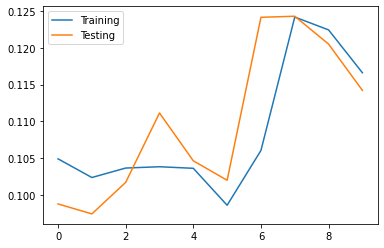

In [28]:
network = Network(**network_params)
with TqdmUpdate() as t: 
    training_accuracies, testing_accuracies = network.train_test_minibatch(
        X,y, test_split=0.2, batch_size=64, epochs=10, progress=t.update_to)
    
plt.plot(training_accuracies, label="Training")
plt.plot(testing_accuracies, label="Testing")
plt.legend()
plt.show()

In [ ]:
# POSSIBLE IMPROVEMENTS: 
# 1. Implement Softmax output activation function. I have read that this 
#    performs better with classification problems since it normalizes the 
#    the output vector to have a norm of 1
# 3. Implement some sort of data set augmentation 
# 4. Implement some sort of convolution and pooling layers for faster computation
# 5. Implement adams optimizer for more efficient gradient descent
# 6. Research more on various error functions that can be used to evaluate the model. 